# Compute Representations
Generate QML representations for the training and test data

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.utils import compute_atomization_energy
from jcesr_ml.qml import FCHLKernel
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from ase.io.xyz import read_xyz
from qml.data import Compound
from io import StringIO
import pickle as pkl
import pandas as pd
import numpy as np
import warnings
import json
import gzip
import os

Numbers to change

In [2]:
max_size = 64  # Maximum size of molecules (intentionally larger than training set)

In [3]:
train_set_size = 3060
test_set_size = 340

In [4]:
project_root = os.path.join('..' )

In [5]:
useful_columns = ['xyz', 'xyz_oxidized', 
                  'filename', 'n_heavy_atoms', 'n_electrons', 'n_atoms',  
                  'u0_g4mp2', 'smiles', 'u0_oxidized_g4mp2',  
                  'G4MP2_IP', 'G4MP2_IP_ASC',  
                  'B3LYP_IP', 'B3LYP_IP_ASC', 
                  'B3LYP_large_IP', 'B3LYP_large_IP_ASC',  
                  'wB97Xd_IP', 'wB97Xd_IP_ASC']

## Load Training Data
Read in the list of datasets to be used to train the models

In [6]:
with open(os.path.join('datasets.json')) as fp:
    datasets = json.load(fp)

Dataset paths are relative to the root of this project

In [7]:
all_data = []
for desc in datasets:
    # Load in the dataset description
    with open(os.path.join(project_root, desc)) as fp:
        desc = json.load(fp)
    
    # Use the description to load in the data
    load_fn = getattr(pd, 'read_' + desc['dataset']['format'])
    dataset = load_fn(
        os.path.join(project_root, desc['dlhub']['files']['data']),
        **desc['dataset']['read_options']
    )
    
    # Add only the needed columns to the training data
    all_data.append(dataset[useful_columns])
    
    del dataset
all_data = pd.concat(all_data)
print('Loaded {} training entries'.format(len(all_data)))

Loaded 3405 training entries


## Select a Training and Validation Set
FCHL becomes computationally intractable to train for large dataset sizes. We select the largest training set size we can tolerate on available hardware by taking a random subset of the training data. [Browning et al.](https://pubs.acs.org/doi/10.1021/acs.jpclett.7b00038) have shown that using Genetic Algorithms to identify optimal training sets can lead to better results than random subsets, and we intend to implement the GA approach in the future.

We also use a distinct subset of the dataset to use as a test set for setting the model hyperparameters. 

In [8]:
train_data, test_data = train_test_split(all_data, train_size=train_set_size, test_size=test_set_size, shuffle=True)

Make these datasets copies to avoid warnings later

In [9]:
train_data = train_data.copy()
test_data = test_data.copy()

We no longer need the full dataset, clearing to save memory

In [10]:
del all_data

## Compute the Representations
We are going to use the [FCHL representation](https://doi.org/10.1063/1.5020710) to describe each molecule. With `qml`, you must pre-compute some bits about each molecule before you can use them on arbitrary molecules. Before computing the represetnation, we need to convert the XYZ file to QML format. This representation is kind of large, so we don't store it.

In [11]:
def compute_rep(x):
    """Generates representation and returns the values"""
    x.generate_fchl_representation(max_size)
    return x.representation

In [12]:
%%time
train_data['rep'] = list(map(compute_rep, map(lambda x: Compound(StringIO(x)), train_data['xyz'])))
test_data['rep'] = list(map(compute_rep, map(lambda x: Compound(StringIO(x)), test_data['xyz'])))

CPU times: user 2.78 s, sys: 242 ms, total: 3.03 s
Wall time: 3.03 s


## Compute Ionization Energy
Performance FCHL is better when operating on the Ionization energy

In [13]:
train_data['deltaIP_g4mp2_b3lyp'] = train_data['G4MP2_IP'] - train_data['B3LYP_IP']

In [14]:
test_data['deltaIP_g4mp2_b3lyp'] = test_data['G4MP2_IP'] - test_data['B3LYP_IP']

In [15]:
train_data['deltaIP_g4mp2_b3lypa'] = train_data['G4MP2_IP'] - train_data['B3LYP_IP_ASC']

In [16]:
test_data['deltaIP_g4mp2_b3lypa'] = test_data['G4MP2_IP'] - test_data['B3LYP_IP_ASC']

In [17]:
train_data['deltaIP_g4mp2a_b3lyp'] = train_data['G4MP2_IP_ASC'] - train_data['B3LYP_IP']

In [18]:
test_data['deltaIP_g4mp2a_b3lyp'] = test_data['G4MP2_IP_ASC'] - test_data['B3LYP_IP']

In [19]:
train_data['deltaIP_g4mp2a_b3lypa'] = train_data['G4MP2_IP_ASC'] - train_data['B3LYP_IP_ASC']

In [20]:
test_data['deltaIP_g4mp2a_b3lypa'] = test_data['G4MP2_IP_ASC'] - test_data['B3LYP_IP_ASC']

In [21]:
train_data['deltaIP_g4mp2_b3lypL'] = train_data['G4MP2_IP'] - train_data['B3LYP_large_IP']

In [22]:
test_data['deltaIP_g4mp2_b3lypL'] = test_data['G4MP2_IP'] - test_data['B3LYP_large_IP']

In [23]:
train_data['deltaIP_g4mp2_b3lypLa'] = train_data['G4MP2_IP'] - train_data['B3LYP_large_IP_ASC']

In [24]:
test_data['deltaIP_g4mp2_b3lypLa'] = test_data['G4MP2_IP'] - test_data['B3LYP_large_IP_ASC']

In [25]:
train_data['deltaIP_g4mp2a_b3lypL'] = train_data['G4MP2_IP_ASC'] - train_data['B3LYP_large_IP']

In [26]:
test_data['deltaIP_g4mp2a_b3lypL'] = test_data['G4MP2_IP_ASC'] - test_data['B3LYP_large_IP']

In [27]:
train_data['deltaIP_g4mp2a_b3lypLa'] = train_data['G4MP2_IP_ASC'] - train_data['B3LYP_large_IP_ASC']

In [28]:
test_data['deltaIP_g4mp2a_b3lypLa'] = test_data['G4MP2_IP_ASC'] - test_data['B3LYP_large_IP_ASC']

In [29]:
train_data['deltaIP_g4mp2_wb97xd'] = train_data['G4MP2_IP'] - train_data['wB97Xd_IP']

In [30]:
test_data['deltaIP_g4mp2_wb97xd'] = test_data['G4MP2_IP'] - test_data['wB97Xd_IP']

In [31]:
train_data['deltaIP_g4mp2_wb97xda'] = train_data['G4MP2_IP'] - train_data['wB97Xd_IP_ASC']

In [32]:
test_data['deltaIP_g4mp2_wb97xda'] = test_data['G4MP2_IP'] - test_data['wB97Xd_IP_ASC']

In [33]:
train_data['deltaIP_g4mp2a_wb97xd'] = train_data['G4MP2_IP_ASC'] - train_data['wB97Xd_IP']

In [34]:
test_data['deltaIP_g4mp2a_wb97xd'] = test_data['G4MP2_IP_ASC'] - test_data['wB97Xd_IP']

In [35]:
train_data['deltaIP_g4mp2a_wb97xda'] = train_data['G4MP2_IP_ASC'] - train_data['wB97Xd_IP_ASC']

In [36]:
test_data['deltaIP_g4mp2a_wb97xda'] = test_data['G4MP2_IP_ASC'] - test_data['wB97Xd_IP_ASC']

## Train a Model 
Train a FCHL model to predict the $\Delta$ between B3LYP and G4MP2. We are going to break it into multiple steps: computing the kernel matrix for the training set and test set. 

### Pre-compute the Kernels
We'll use them many times during the model tuning, and they are 

In [37]:
fchl = FCHLKernel()

In [38]:
%%time
K_train = fchl.fit_transform(train_data['rep'].tolist())

CPU times: user 3h 11min 31s, sys: 1.21 s, total: 3h 11min 32s
Wall time: 5min 20s


In [39]:
%%time
K_test = fchl.transform(test_data['rep'].tolist())

CPU times: user 44min 28s, sys: 1.19 s, total: 44min 29s
Wall time: 1min 15s


### Adjust the Hyperparameters for B3LYP IPs and G4MP2 IPs
Determine how much regularization to use

First, without regularization

In [40]:
lr = LinearRegression(fit_intercept=False)
y_pred = lr.fit(K_train, train_data['deltaIP_g4mp2_b3lyp']).predict(K_test)
lr_mae = mean_absolute_error(y_pred, test_data['deltaIP_g4mp2_b3lyp'])
print('Without regularization: {:.2e}'.format(lr_mae))

Without regularization: 1.26e-01


Run the model with ridge parameters

In [41]:
lambdas = np.logspace(-16, 0, 128)

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ridge_mae = [
        mean_absolute_error(Ridge(alpha=l, fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2_b3lyp']).predict(K_test), test_data['deltaIP_g4mp2_b3lyp'])
        for l in lambdas
    ]
    print('Best regularization: {:.2e} at lambda: {:.1e}'.format(np.min(ridge_mae), lambdas[np.argmin(ridge_mae)]))

Best regularization: 5.80e-02 at lambda: 2.7e-10


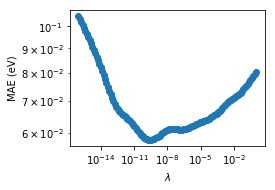

In [43]:
fig, ax  = plt.subplots()

ax.loglog(lambdas, ridge_mae, 'o--')

ax.set_ylabel('MAE (eV)')
ax.set_xlabel('$\lambda$')

fig.set_size_inches(3.5, 2.5)

Get the right linear regression tool. Ridge if it works better, Linear Regression otherwise

In [44]:
model = lr if lr_mae < np.min(ridge_mae) else Ridge(alpha=lambdas[np.argmin(ridge_mae)], fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2_b3lyp'])


In [45]:
model

Ridge(alpha=2.661931346126126e-10, copy_X=True, fit_intercept=False,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

## Make the model
Combine the two components and save it to disk

In [46]:
#del K_train # Huge and no longer needed

In [47]:
model = Pipeline([
    ('kernel', fchl),
    ('model', model)
])

In [48]:
with gzip.open('model_deltaIP_g4mp2_b3lyp.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)

In [49]:
train_data.to_pickle('train_data_deltaIP_g4mp2_b3lyp.pkl.gz')

In [50]:
test_data.to_pickle('test_data_deltaIP_g4mp2_b3lyp.pkl.gz')

### Adjust the Hyperparameters for B3LYP IPs and G4MP2-A IPs
Determine how much regularization to use

First, without regularization

In [51]:
lr = LinearRegression(fit_intercept=False)
y_pred = lr.fit(K_train, train_data['deltaIP_g4mp2a_b3lyp']).predict(K_test)
lr_mae = mean_absolute_error(y_pred, test_data['deltaIP_g4mp2a_b3lyp'])
print('Without regularization: {:.2e}'.format(lr_mae))

Without regularization: 1.26e-01


Run the model with ridge parameters

In [52]:
lambdas = np.logspace(-16, 0, 128)

In [53]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ridge_mae = [
        mean_absolute_error(Ridge(alpha=l, fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2a_b3lyp']).predict(K_test), test_data['deltaIP_g4mp2a_b3lyp'])
        for l in lambdas
    ]
    print('Best regularization: {:.2e} at lambda: {:.1e}'.format(np.min(ridge_mae), lambdas[np.argmin(ridge_mae)]))

Best regularization: 5.80e-02 at lambda: 2.7e-10


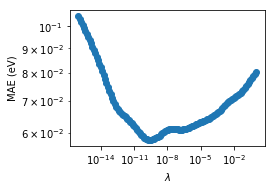

In [54]:
fig, ax  = plt.subplots()

ax.loglog(lambdas, ridge_mae, 'o--')

ax.set_ylabel('MAE (eV)')
ax.set_xlabel('$\lambda$')

fig.set_size_inches(3.5, 2.5)

Get the right linear regression tool. Ridge if it works better, Linear Regression otherwise

In [55]:
model = lr if lr_mae < np.min(ridge_mae) else Ridge(alpha=lambdas[np.argmin(ridge_mae)], fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2a_b3lyp'])

In [56]:
model

Ridge(alpha=2.661931346126126e-10, copy_X=True, fit_intercept=False,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

## Make the model
Combine the two components and save it to disk

In [57]:
#del K_train # Huge and no longer needed

In [58]:
model = Pipeline([
    ('kernel', fchl),
    ('model', model)
])

In [59]:
with gzip.open('model_deltaIP_g4mp2a_b3lyp.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)

In [60]:
train_data.to_pickle('train_data_deltaIP_g4mp2a_b3lyp.pkl.gz')

In [61]:
test_data.to_pickle('test_data_deltaIP_g4mp2a_b3lyp.pkl.gz')

### Adjust the Hyperparameters for B3LYP-A and G4MP2 IPs
Determine how much regularization to use

First, without regularization

In [62]:
lr = LinearRegression(fit_intercept=False)
y_pred = lr.fit(K_train, train_data['deltaIP_g4mp2_b3lypa']).predict(K_test)
lr_mae = mean_absolute_error(y_pred, test_data['deltaIP_g4mp2_b3lypa'])
print('Without regularization: {:.2e}'.format(lr_mae))

Without regularization: 1.26e-01


Run the model with ridge parameters

In [63]:
lambdas = np.logspace(-16, 0, 128)

In [64]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ridge_mae = [
        mean_absolute_error(Ridge(alpha=l, fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2_b3lypa']).predict(K_test), test_data['deltaIP_g4mp2_b3lypa'])
        for l in lambdas
    ]
    print('Best regularization: {:.2e} at lambda: {:.1e}'.format(np.min(ridge_mae), lambdas[np.argmin(ridge_mae)]))

Best regularization: 5.80e-02 at lambda: 2.7e-10


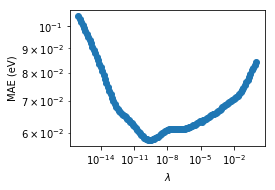

In [65]:
fig, ax  = plt.subplots()

ax.loglog(lambdas, ridge_mae, 'o--')

ax.set_ylabel('MAE (eV)')
ax.set_xlabel('$\lambda$')

fig.set_size_inches(3.5, 2.5)

Get the right linear regression tool. Ridge if it works better, Linear Regression otherwise

In [66]:
model = lr if lr_mae < np.min(ridge_mae) else Ridge(alpha=lambdas[np.argmin(ridge_mae)], fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2_b3lypa'])


In [67]:
model

Ridge(alpha=2.661931346126126e-10, copy_X=True, fit_intercept=False,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

## Make the model
Combine the two components and save it to disk

In [68]:
#del K_train # Huge and no longer needed

In [69]:
model = Pipeline([
    ('kernel', fchl),
    ('model', model)
])

In [70]:
with gzip.open('model_deltaIP_g4mp2_b3lypa.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)

In [71]:
train_data.to_pickle('train_data_deltaIP_g4mp2_b3lypa.pkl.gz')

In [72]:
test_data.to_pickle('test_data_deltaIP_g4mp2_b3lypa.pkl.gz')

### Adjust the Hyperparameters for B3LYP-A and G4MP2-A IPs
Determine how much regularization to use

First, without regularization

In [73]:
lr = LinearRegression(fit_intercept=False)
y_pred = lr.fit(K_train, train_data['deltaIP_g4mp2a_b3lypa']).predict(K_test)
lr_mae = mean_absolute_error(y_pred, test_data['deltaIP_g4mp2a_b3lypa'])
print('Without regularization: {:.2e}'.format(lr_mae))

Without regularization: 1.26e-01


Run the model with ridge parameters

In [74]:
lambdas = np.logspace(-16, 0, 128)

In [75]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ridge_mae = [
        mean_absolute_error(Ridge(alpha=l, fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2a_b3lypa']).predict(K_test), test_data['deltaIP_g4mp2a_b3lypa'])
        for l in lambdas
    ]
    print('Best regularization: {:.2e} at lambda: {:.1e}'.format(np.min(ridge_mae), lambdas[np.argmin(ridge_mae)]))

Best regularization: 5.80e-02 at lambda: 2.7e-10


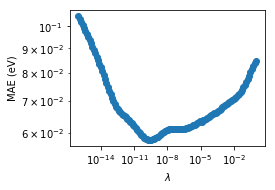

In [76]:
fig, ax  = plt.subplots()

ax.loglog(lambdas, ridge_mae, 'o--')

ax.set_ylabel('MAE (eV)')
ax.set_xlabel('$\lambda$')

fig.set_size_inches(3.5, 2.5)

Get the right linear regression tool. Ridge if it works better, Linear Regression otherwise

In [77]:
model = lr if lr_mae < np.min(ridge_mae) else Ridge(alpha=lambdas[np.argmin(ridge_mae)], fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2a_b3lypa'])

In [78]:
model

Ridge(alpha=2.661931346126126e-10, copy_X=True, fit_intercept=False,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

## Make the model
Combine the two components and save it to disk

In [79]:
#del K_train # Huge and no longer needed

In [80]:
model = Pipeline([
    ('kernel', fchl),
    ('model', model)
])

In [81]:
with gzip.open('model_deltaIP_g4mp2a_b3lypa.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)

In [82]:
train_data.to_pickle('train_data_deltaIP_g4mp2a_b3lypa.pkl.gz')

In [83]:
test_data.to_pickle('test_data_deltaIP_g4mp2a_b3lypa.pkl.gz')

### Adjust the Hyperparameters for B3LYP-L and G4MP2 IPs
Determine how much regularization to use

First, without regularization

In [84]:
lr = LinearRegression(fit_intercept=False)
y_pred = lr.fit(K_train, train_data['deltaIP_g4mp2_b3lypL']).predict(K_test)
lr_mae = mean_absolute_error(y_pred, test_data['deltaIP_g4mp2_b3lypL'])
print('Without regularization: {:.2e}'.format(lr_mae))

Without regularization: 1.27e-01


Run the model with ridge parameters

In [85]:
lambdas = np.logspace(-16, 0, 128)

In [86]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ridge_mae = [
        mean_absolute_error(Ridge(alpha=l, fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2_b3lypL']).predict(K_test), test_data['deltaIP_g4mp2_b3lypL'])
        for l in lambdas
    ]
    print('Best regularization: {:.2e} at lambda: {:.1e}'.format(np.min(ridge_mae), lambdas[np.argmin(ridge_mae)]))

Best regularization: 5.96e-02 at lambda: 3.6e-10


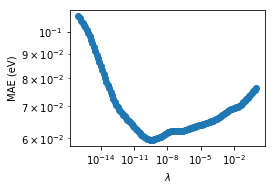

In [87]:
fig, ax  = plt.subplots()

ax.loglog(lambdas, ridge_mae, 'o--')

ax.set_ylabel('MAE (eV)')
ax.set_xlabel('$\lambda$')

fig.set_size_inches(3.5, 2.5)

Get the right linear regression tool. Ridge if it works better, Linear Regression otherwise

In [88]:
model = lr if lr_mae < np.min(ridge_mae) else Ridge(alpha=lambdas[np.argmin(ridge_mae)], fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2_b3lypL'])

In [89]:
model

Ridge(alpha=3.557796490339488e-10, copy_X=True, fit_intercept=False,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

## Make the model
Combine the two components and save it to disk

In [90]:
#del K_train # Huge and no longer needed

In [91]:
model = Pipeline([
    ('kernel', fchl),
    ('model', model)
])

In [92]:
with gzip.open('model_deltaIP_g4mp2_b3lypL.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)

In [93]:
train_data.to_pickle('train_data_deltaIP_g4mp2_b3lypL.pkl.gz')

In [94]:
test_data.to_pickle('test_data_deltaIP_g4mp2_b3lypL.pkl.gz')

### Adjust the Hyperparameters for B3LYP-L and G4MP2-A IPs
Determine how much regularization to use

First, without regularization

In [95]:
lr = LinearRegression(fit_intercept=False)
y_pred = lr.fit(K_train, train_data['deltaIP_g4mp2a_b3lypL']).predict(K_test)
lr_mae = mean_absolute_error(y_pred, test_data['deltaIP_g4mp2a_b3lypL'])
print('Without regularization: {:.2e}'.format(lr_mae))

Without regularization: 1.27e-01


Run the model with ridge parameters

In [96]:
lambdas = np.logspace(-16, 0, 128)

In [97]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ridge_mae = [
        mean_absolute_error(Ridge(alpha=l, fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2a_b3lypL']).predict(K_test), test_data['deltaIP_g4mp2a_b3lypL'])
        for l in lambdas
    ]
    print('Best regularization: {:.2e} at lambda: {:.1e}'.format(np.min(ridge_mae), lambdas[np.argmin(ridge_mae)]))

Best regularization: 5.96e-02 at lambda: 3.6e-10


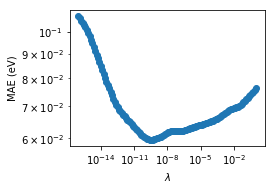

In [98]:
fig, ax  = plt.subplots()

ax.loglog(lambdas, ridge_mae, 'o--')

ax.set_ylabel('MAE (eV)')
ax.set_xlabel('$\lambda$')

fig.set_size_inches(3.5, 2.5)

Get the right linear regression tool. Ridge if it works better, Linear Regression otherwise

In [99]:
model = lr if lr_mae < np.min(ridge_mae) else Ridge(alpha=lambdas[np.argmin(ridge_mae)], fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2a_b3lypL'])

In [100]:
model

Ridge(alpha=3.557796490339488e-10, copy_X=True, fit_intercept=False,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

## Make the model
Combine the two components and save it to disk

In [101]:
#del K_train # Huge and no longer needed

In [102]:
model = Pipeline([
    ('kernel', fchl),
    ('model', model)
])

In [103]:
with gzip.open('model_deltaIP_g4mp2a_b3lypL.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)

In [104]:
train_data.to_pickle('train_data_deltaIP_g4mp2a_b3lypL.pkl.gz')

In [105]:
test_data.to_pickle('test_data_deltaIP_g4mp2a_b3lypL.pkl.gz')

### Adjust the Hyperparameters for B3LYP-L-A and G4MP2 IPs
Determine how much regularization to use

First, without regularization

In [106]:
lr = LinearRegression(fit_intercept=False)
y_pred = lr.fit(K_train, train_data['deltaIP_g4mp2_b3lypLa']).predict(K_test)
lr_mae = mean_absolute_error(y_pred, test_data['deltaIP_g4mp2_b3lypLa'])
print('Without regularization: {:.2e}'.format(lr_mae))

Without regularization: 1.27e-01


Run the model with ridge parameters

In [107]:
lambdas = np.logspace(-16, 0, 128)

In [108]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ridge_mae = [
        mean_absolute_error(Ridge(alpha=l, fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2_b3lypLa']).predict(K_test), test_data['deltaIP_g4mp2_b3lypLa'])
        for l in lambdas
    ]
    print('Best regularization: {:.2e} at lambda: {:.1e}'.format(np.min(ridge_mae), lambdas[np.argmin(ridge_mae)]))

Best regularization: 5.96e-02 at lambda: 3.6e-10


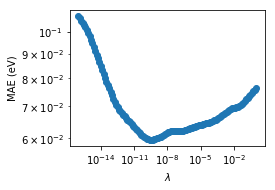

In [109]:
fig, ax  = plt.subplots()

ax.loglog(lambdas, ridge_mae, 'o--')

ax.set_ylabel('MAE (eV)')
ax.set_xlabel('$\lambda$')

fig.set_size_inches(3.5, 2.5)

Get the right linear regression tool. Ridge if it works better, Linear Regression otherwise

In [110]:
model = lr if lr_mae < np.min(ridge_mae) else Ridge(alpha=lambdas[np.argmin(ridge_mae)], fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2_b3lypLa'])

In [111]:
model

Ridge(alpha=3.557796490339488e-10, copy_X=True, fit_intercept=False,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

## Make the model
Combine the two components and save it to disk

In [112]:
#del K_train # Huge and no longer needed

In [113]:
model = Pipeline([
    ('kernel', fchl),
    ('model', model)
])

In [114]:
with gzip.open('model_deltaIP_g4mp2_b3lypLa.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)

In [115]:
train_data.to_pickle('train_data_deltaIP_g4mp2_b3lypLa.pkl.gz')

In [116]:
test_data.to_pickle('test_data_deltaIP_g4mp2_b3lypLa.pkl.gz')

### Adjust the Hyperparameters for B3LYP-L-A and G4MP2-A IPs
Determine how much regularization to use

First, without regularization

In [117]:
lr = LinearRegression(fit_intercept=False)
y_pred = lr.fit(K_train, train_data['deltaIP_g4mp2a_b3lypLa']).predict(K_test)
lr_mae = mean_absolute_error(y_pred, test_data['deltaIP_g4mp2a_b3lypLa'])
print('Without regularization: {:.2e}'.format(lr_mae))

Without regularization: 1.27e-01


Run the model with ridge parameters

In [118]:
lambdas = np.logspace(-16, 0, 128)

In [119]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ridge_mae = [
        mean_absolute_error(Ridge(alpha=l, fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2a_b3lypLa']).predict(K_test), test_data['deltaIP_g4mp2a_b3lypLa'])
        for l in lambdas
    ]
    print('Best regularization: {:.2e} at lambda: {:.1e}'.format(np.min(ridge_mae), lambdas[np.argmin(ridge_mae)]))

Best regularization: 5.96e-02 at lambda: 3.6e-10


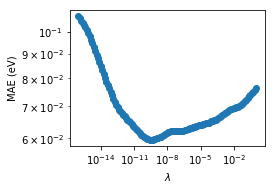

In [120]:
fig, ax  = plt.subplots()

ax.loglog(lambdas, ridge_mae, 'o--')

ax.set_ylabel('MAE (eV)')
ax.set_xlabel('$\lambda$')

fig.set_size_inches(3.5, 2.5)

Get the right linear regression tool. Ridge if it works better, Linear Regression otherwise

In [121]:
model = lr if lr_mae < np.min(ridge_mae) else Ridge(alpha=lambdas[np.argmin(ridge_mae)], fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2a_b3lypLa'])

In [122]:
model

Ridge(alpha=3.557796490339488e-10, copy_X=True, fit_intercept=False,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

## Make the model
Combine the two components and save it to disk

In [123]:
#del K_train # Huge and no longer needed

In [124]:
model = Pipeline([
    ('kernel', fchl),
    ('model', model)
])

In [125]:
with gzip.open('model_deltaIP_g4mp2a_b3lypLa.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)

In [126]:
train_data.to_pickle('train_data_deltaIP_g4mp2a_b3lypLa.pkl.gz')

In [127]:
test_data.to_pickle('test_data_deltaIP_g4mp2a_b3lypLa.pkl.gz')

### Adjust the Hyperparameters for wB97Xd and G4MP2 IPs
Determine how much regularization to use

First, without regularization

In [128]:
lr = LinearRegression(fit_intercept=False)
y_pred = lr.fit(K_train, train_data['deltaIP_g4mp2_wb97xd']).predict(K_test)
lr_mae = mean_absolute_error(y_pred, test_data['deltaIP_g4mp2_wb97xd'])
print('Without regularization: {:.2e}'.format(lr_mae))

Without regularization: 7.43e-02


Run the model with ridge parameters

In [129]:
lambdas = np.logspace(-16, 0, 128)

In [130]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ridge_mae = [
        mean_absolute_error(Ridge(alpha=l, fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2_wb97xd']).predict(K_test), test_data['deltaIP_g4mp2_wb97xd'])
        for l in lambdas
    ]
    print('Best regularization: {:.2e} at lambda: {:.1e}'.format(np.min(ridge_mae), lambdas[np.argmin(ridge_mae)]))

Best regularization: 3.18e-02 at lambda: 4.8e-09


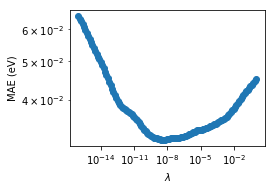

In [131]:
fig, ax  = plt.subplots()

ax.loglog(lambdas, ridge_mae, 'o--')

ax.set_ylabel('MAE (eV)')
ax.set_xlabel('$\lambda$')

fig.set_size_inches(3.5, 2.5)

Get the right linear regression tool. Ridge if it works better, Linear Regression otherwise

In [132]:
model = lr if lr_mae < np.min(ridge_mae) else Ridge(alpha=lambdas[np.argmin(ridge_mae)], fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2_wb97xd'])


In [133]:
model

Ridge(alpha=4.842162612301513e-09, copy_X=True, fit_intercept=False,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

## Make the model
Combine the two components and save it to disk

In [134]:
#del K_train # Huge and no longer needed

In [135]:
model = Pipeline([
    ('kernel', fchl),
    ('model', model)
])

In [136]:
with gzip.open('model_deltaIP_g4mp2_wb97xd.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)

In [137]:
train_data.to_pickle('train_data_deltaIP_g4mp2_wb97xd.pkl.gz')

In [138]:
test_data.to_pickle('test_data_deltaIP_g4mp2_wb97xd.pkl.gz')

### Adjust the Hyperparameters for wB97Xd and G4MP2-A IPs
Determine how much regularization to use

First, without regularization

In [139]:
lr = LinearRegression(fit_intercept=False)
y_pred = lr.fit(K_train, train_data['deltaIP_g4mp2a_wb97xd']).predict(K_test)
lr_mae = mean_absolute_error(y_pred, test_data['deltaIP_g4mp2a_wb97xd'])
print('Without regularization: {:.2e}'.format(lr_mae))

Without regularization: 7.43e-02


Run the model with ridge parameters

In [140]:
lambdas = np.logspace(-16, 0, 128)

In [141]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ridge_mae = [
        mean_absolute_error(Ridge(alpha=l, fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2a_wb97xd']).predict(K_test), test_data['deltaIP_g4mp2a_wb97xd'])
        for l in lambdas
    ]
    print('Best regularization: {:.2e} at lambda: {:.1e}'.format(np.min(ridge_mae), lambdas[np.argmin(ridge_mae)]))

Best regularization: 3.18e-02 at lambda: 4.8e-09


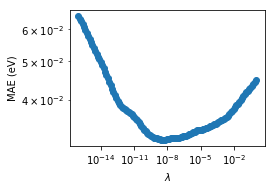

In [142]:
fig, ax  = plt.subplots()

ax.loglog(lambdas, ridge_mae, 'o--')

ax.set_ylabel('MAE (eV)')
ax.set_xlabel('$\lambda$')

fig.set_size_inches(3.5, 2.5)

Get the right linear regression tool. Ridge if it works better, Linear Regression otherwise

In [143]:
model = lr if lr_mae < np.min(ridge_mae) else Ridge(alpha=lambdas[np.argmin(ridge_mae)], fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2a_wb97xd'])


In [144]:
model

Ridge(alpha=4.842162612301513e-09, copy_X=True, fit_intercept=False,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

## Make the model
Combine the two components and save it to disk

In [145]:
#del K_train # Huge and no longer needed

In [146]:
model = Pipeline([
    ('kernel', fchl),
    ('model', model)
])

In [147]:
with gzip.open('model_deltaIP_g4mp2a_wb97xd.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)

In [148]:
train_data.to_pickle('train_data_deltaIP_g4mp2a_wb97xd.pkl.gz')

In [149]:
test_data.to_pickle('test_data_deltaIP_g4mp2a_wb97xd.pkl.gz')

### Adjust the Hyperparameters for wB97Xd-A and G4MP2 IPs
Determine how much regularization to use

First, without regularization

In [150]:
lr = LinearRegression(fit_intercept=False)
y_pred = lr.fit(K_train, train_data['deltaIP_g4mp2_wb97xda']).predict(K_test)
lr_mae = mean_absolute_error(y_pred, test_data['deltaIP_g4mp2_wb97xda'])
print('Without regularization: {:.2e}'.format(lr_mae))

Without regularization: 7.43e-02


Run the model with ridge parameters

In [151]:
lambdas = np.logspace(-16, 0, 128)

In [152]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ridge_mae = [
        mean_absolute_error(Ridge(alpha=l, fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2_wb97xda']).predict(K_test), test_data['deltaIP_g4mp2_wb97xda'])
        for l in lambdas
    ]
    print('Best regularization: {:.2e} at lambda: {:.1e}'.format(np.min(ridge_mae), lambdas[np.argmin(ridge_mae)]))

Best regularization: 3.18e-02 at lambda: 4.8e-09


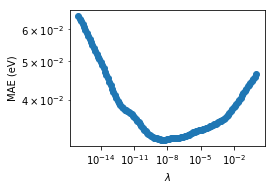

In [153]:
fig, ax  = plt.subplots()

ax.loglog(lambdas, ridge_mae, 'o--')

ax.set_ylabel('MAE (eV)')
ax.set_xlabel('$\lambda$')

fig.set_size_inches(3.5, 2.5)

Get the right linear regression tool. Ridge if it works better, Linear Regression otherwise

In [154]:
model = lr if lr_mae < np.min(ridge_mae) else Ridge(alpha=lambdas[np.argmin(ridge_mae)], fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2_wb97xda'])


In [155]:
model

Ridge(alpha=4.842162612301513e-09, copy_X=True, fit_intercept=False,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

## Make the model
Combine the two components and save it to disk

In [156]:
#del K_train # Huge and no longer needed

In [157]:
model = Pipeline([
    ('kernel', fchl),
    ('model', model)
])

In [158]:
with gzip.open('model_deltaIP_g4mp2_wb97xda.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)

In [159]:
train_data.to_pickle('train_data_deltaIP_g4mp2_wb97xda.pkl.gz')

In [160]:
test_data.to_pickle('test_data_deltaIP_g4mp2_wb97xda.pkl.gz')

### Adjust the Hyperparameters for wB97Xd-A and G4MP2-A IPs
Determine how much regularization to use

First, without regularization

In [161]:
lr = LinearRegression(fit_intercept=False)
y_pred = lr.fit(K_train, train_data['deltaIP_g4mp2a_wb97xda']).predict(K_test)
lr_mae = mean_absolute_error(y_pred, test_data['deltaIP_g4mp2a_wb97xda'])
print('Without regularization: {:.2e}'.format(lr_mae))

Without regularization: 7.43e-02


Run the model with ridge parameters

In [162]:
lambdas = np.logspace(-16, 0, 128)

In [163]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ridge_mae = [
        mean_absolute_error(Ridge(alpha=l, fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2a_wb97xda']).predict(K_test), test_data['deltaIP_g4mp2a_wb97xda'])
        for l in lambdas
    ]
    print('Best regularization: {:.2e} at lambda: {:.1e}'.format(np.min(ridge_mae), lambdas[np.argmin(ridge_mae)]))

Best regularization: 3.18e-02 at lambda: 4.8e-09


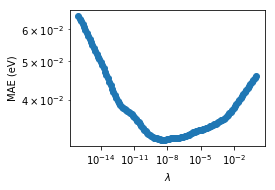

In [164]:
fig, ax  = plt.subplots()

ax.loglog(lambdas, ridge_mae, 'o--')

ax.set_ylabel('MAE (eV)')
ax.set_xlabel('$\lambda$')

fig.set_size_inches(3.5, 2.5)

Get the right linear regression tool. Ridge if it works better, Linear Regression otherwise

In [165]:
model = lr if lr_mae < np.min(ridge_mae) else Ridge(alpha=lambdas[np.argmin(ridge_mae)], fit_intercept=False).fit(K_train, train_data['deltaIP_g4mp2a_wb97xda'])


In [166]:
model

Ridge(alpha=4.842162612301513e-09, copy_X=True, fit_intercept=False,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

## Make the model
Combine the two components and save it to disk

In [167]:
del K_train # Huge and no longer needed

In [168]:
model = Pipeline([
    ('kernel', fchl),
    ('model', model)
])

In [169]:
with gzip.open('model_deltaIP_g4mp2a_wb97xda.pkl.gz', 'wb') as fp:
    pkl.dump(model, fp)

In [170]:
train_data.to_pickle('train_data_deltaIP_g4mp2a_wb97xda.pkl.gz')

In [171]:
test_data.to_pickle('test_data_deltaIP_g4mp2a_wb97xda.pkl.gz')